In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('../')

In [ ]:
from traffic_light_color_detection.model import ColorSpace
from traffic_light_color_detection.color_spaces import ColorModelFactory

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import cv2
import time
import pandas as pd
import numpy as np
import json

from PIL import Image
import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

DIR_INPUT = '/content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/kaggle_dataset/'
DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "train_dataset/test_images/"

In [ ]:
files = os.listdir(DIR_IMAGES)

# Count the number of images
num_images = len(files)

print(f"Number of images: {num_images}")

Number of images: 2600


## Extract labels about bounding box and light color from json file

In [ ]:
with open(DIR_INPUT+"/train_dataset/train.json") as f:
    data_dict = json.load(f)

# Create a list containing the data rows of the table
data = []

# Loop through the elements in the annotations list
for annotation in data_dict['annotations']:
    # Get general bounding box information
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']

    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })


# Create a DataFrame from a list of data and save it to a CSV file
df = pd.DataFrame(data)
df.to_csv('traffic_lights.csv', index=False)

In [ ]:
data_tf = pd.read_csv('/content/traffic_lights.csv')


In [ ]:
data_tf

filename    xmin    ymin    xmax    ymax  color
0     train_images\00001.jpg  1026.5   741.8  1077.5   910.9    red
1     train_images\00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     train_images\00003.jpg  2574.3   868.7  2632.3   887.1    red
3     train_images\00003.jpg  2252.1   899.6  2300.8   918.7  green
4     train_images\00004.jpg   833.3  1163.2   843.6  1184.8  green
...                      ...     ...     ...     ...     ...    ...
9417  train_images\03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  train_images\03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  train_images\03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  train_images\03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  train_images\03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]

In [ ]:
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('traffic_lights_labels.csv', index=False)

In [ ]:
df = pd.read_csv('/content/traffic_lights_labels.csv')
df

filename    xmin    ymin    xmax    ymax  color
0     00001.jpg  1026.5   741.8  1077.5   910.9    red
1     00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     00003.jpg  2574.3   868.7  2632.3   887.1    red
3     00003.jpg  2252.1   899.6  2300.8   918.7  green
4     00004.jpg   833.3  1163.2   843.6  1184.8  green
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]

## Data exploration and visualization

In [ ]:
df.head()

filename    xmin    ymin    xmax    ymax  color
0  00001.jpg  1026.5   741.8  1077.5   910.9    red
1  00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2  00003.jpg  2574.3   868.7  2632.3   887.1    red
3  00003.jpg  2252.1   899.6  2300.8   918.7  green
4  00004.jpg   833.3  1163.2   843.6  1184.8  green

In [ ]:
unq_values = df["filename"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  9422
Unique Images:  2470

> Null Values in each column <
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
color       0
dtype: int64


In [ ]:
classes = df["color"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  3

> Classes <
 ['red' 'green' 'yellow']


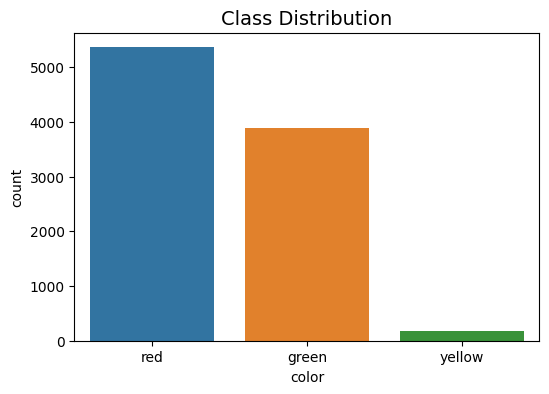

In [ ]:
plt.figure(figsize=(6, 4))
plt.title('Class Distribution', fontsize= 14)
sns.countplot(x = "color", data = df);

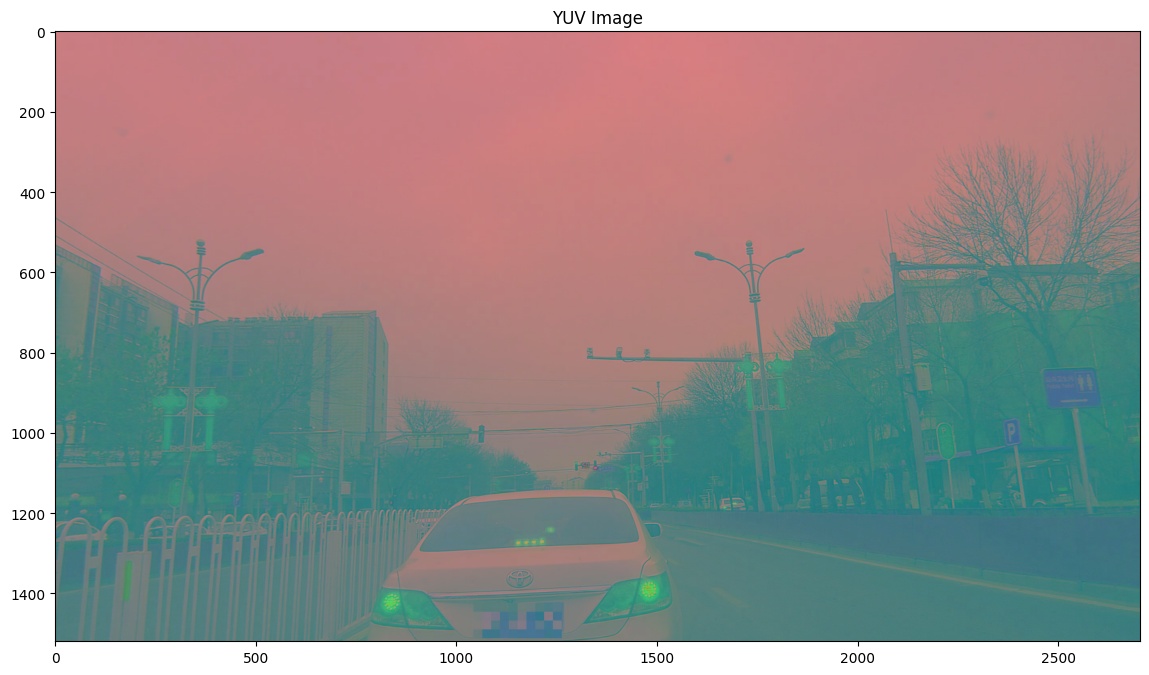

In [ ]:
my_image_name = "00004.jpg"
my_img_path = os.path.join(DIR_IMAGES, my_image_name)

my_image = cv2.imread(my_img_path, cv2.IMREAD_COLOR)
my_yuv_image = ColorModelFactory.to_color_space(ColorSpace.YUV, my_image)
fig, ax = plt.subplots(1, 1, figsize = (14, 14))
ax.set_title('YUV Image')
ax.imshow(my_yuv_image)
plt.show()

In [ ]:
def plot_img(image_name):

    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax = ax.flatten()

    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)

    my_image_name = "00004.jpg"
    my_img_path = os.path.join(DIR_IMAGES, my_image_name)

    image = cv2.imread(my_img_path, cv2.IMREAD_COLOR)
    image = ColorModelFactory.to_color_space(ColorSpace.YCBCr, my_image)
    image2 = image

    ax[0].set_title('Original Image')
    ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

error: ignored

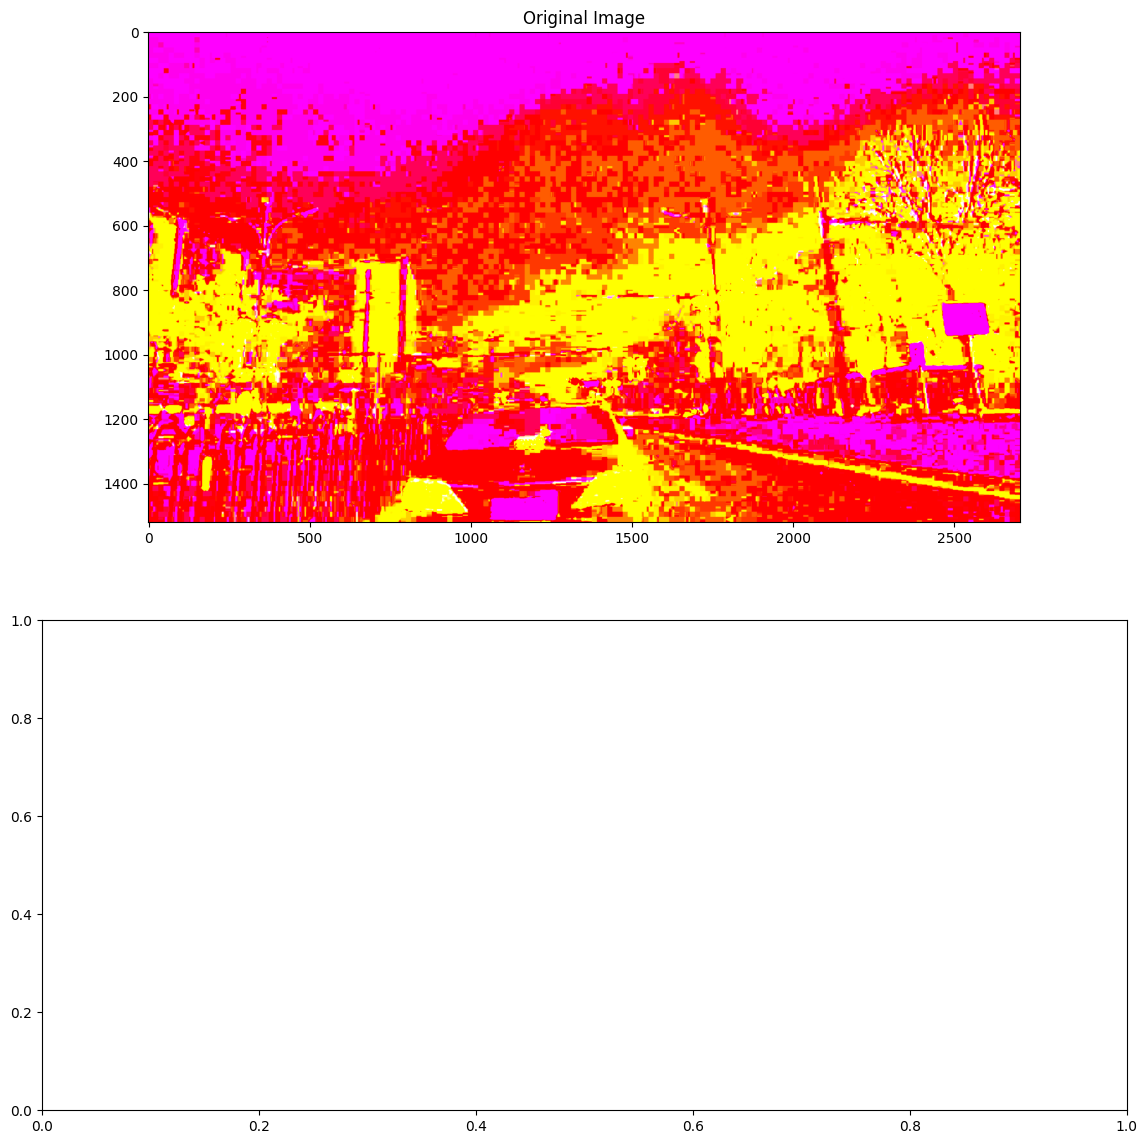

In [ ]:
plot_img("00004.jpg")

## Preparing Dataset for Training

In [ ]:
_classes = np.insert(classes, 0, "background", axis=0)
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [ ]:
class TrafficLightDetectionDataset(Dataset):

    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):

        super().__init__()

        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index: int):

        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]

        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        if image is None:
                print("Missing image :", self.image_dir + image_name, cv2.IMREAD_COLOR)
                raise ValueError(f"Failed to load image at index {index}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.mode == 'train':

            #Get bounding box co-ordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            #Getting labels for each box
            temp_labels = records[['color']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            # Resize the image and the bounding boxes
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['area'] = torch.as_tensor(area, dtype=torch.float32)

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name

        elif self.mode == 'test':
            # Resize the image
            height, width, _ = image.shape
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image = cv2.resize(image, (new_width, new_height))

            if self.transforms:
                image = self.transforms(image)

            return image, image_name


In [ ]:
df

filename    xmin    ymin    xmax    ymax  color
0     00001.jpg  1026.5   741.8  1077.5   910.9    red
1     00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     00003.jpg  2574.3   868.7  2632.3   887.1    red
3     00003.jpg  2252.1   899.6  2300.8   918.7  green
4     00004.jpg   833.3  1163.2   843.6  1184.8  green
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]

# Custom train test and valid

In [ ]:
from sklearn.model_selection import train_test_split

def custom_transform(image: np.ndarray):
    transformed_image = ColorModelFactory.to_color_space(ColorSpace.YUV, image)
    # transformed_image = ColorModelFactory.to_color_space(ColorSpace.YCBCr, image)
    # transformed_image = ColorModelFactory.to_color_space(ColorSpace.HSV, image)

    tensor_image = T.ToTensor()(transformed_image)
    return  tensor_image / 255.0

# Example of how to use the transformation
transform = T.Compose([
    T.Lambda(custom_transform),
    # Add other transformations as needed
])

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))

# Get unique image names
image_names = df['filename'].unique()

# Split the image names into train, test, and validation sets
train_names, test_valid_names = train_test_split(image_names, test_size=0.3, random_state=42)
test_names, valid_names = train_test_split(test_valid_names, test_size=0.5, random_state=42)

# Create subsets of the DataFrame for train, test, and validation
train_df = df[df['filename'].isin(train_names)]
test_df = df[df['filename'].isin(test_names)]
valid_df = df[df['filename'].isin(valid_names)]

# Dataset object for each subset
train_dataset = TrafficLightDetectionDataset(train_df, DIR_IMAGES, mode='train', transforms=transform)
test_dataset = TrafficLightDetectionDataset(test_df, DIR_IMAGES, mode='train', transforms=transform)
valid_dataset = TrafficLightDetectionDataset(valid_df, DIR_IMAGES, mode='train', transforms=transform)

# DataLoaders for each subset
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)
valid_data_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [ ]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [ ]:
print(device)

cuda


## Create model

In [ ]:
# Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Preparing model for training

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
model.to(device)
# No of epochs
epochs = 7

## Training model

In [ ]:
# Training model

itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        # tqdm

        # Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())

        # Reseting Gradients
        optimizer.zero_grad()

        # Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        # Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)

        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n") ## {out}
        itr += 1
    lr_scheduler.step()

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')


    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")

 69%|██████▉   | 300/433 [05:48<02:28,  1.12s/it]


 Iteration #300 loss: 0.5540 



100%|██████████| 433/433 [08:18<00:00,  1.15s/it]


Epoch: 1
Epoch train loss is 0.7822
Time elapsed:  498.39406299591064


 39%|███▊      | 167/433 [03:11<04:59,  1.13s/it]


 Iteration #600 loss: 0.6124 



100%|██████████| 433/433 [08:12<00:00,  1.14s/it]


Epoch: 2
Epoch train loss is 0.7723
Time elapsed:  492.3760359287262


  8%|▊         | 34/433 [00:40<07:28,  1.12s/it]


 Iteration #900 loss: 0.6211 



 77%|███████▋  | 334/433 [06:21<01:52,  1.14s/it]


 Iteration #1200 loss: 0.7192 



100%|██████████| 433/433 [08:13<00:00,  1.14s/it]


Epoch: 3
Epoch train loss is 0.5747
Time elapsed:  493.7547974586487


 46%|████▋     | 201/433 [03:52<04:28,  1.16s/it]


 Iteration #1500 loss: 0.4309 



100%|██████████| 433/433 [08:15<00:00,  1.14s/it]


Epoch: 4
Epoch train loss is 0.5563
Time elapsed:  495.1897699832916


 16%|█▌        | 68/433 [01:19<07:03,  1.16s/it]


 Iteration #1800 loss: 0.2628 



 85%|████████▍ | 368/433 [07:00<01:14,  1.14s/it]


 Iteration #2100 loss: 0.5075 



100%|██████████| 433/433 [08:14<00:00,  1.14s/it]


Epoch: 5
Epoch train loss is 0.5422
Time elapsed:  494.1140515804291


 54%|█████▍    | 235/433 [04:29<03:42,  1.12s/it]


 Iteration #2400 loss: 0.5106 



100%|██████████| 433/433 [08:14<00:00,  1.14s/it]


Epoch: 6
Epoch train loss is 0.5401
Time elapsed:  494.5877468585968


 24%|██▎       | 102/433 [01:59<06:12,  1.13s/it]


 Iteration #2700 loss: 0.4258 



 93%|█████████▎| 402/433 [07:42<00:36,  1.16s/it]


 Iteration #3000 loss: 0.4650 



100%|██████████| 433/433 [08:16<00:00,  1.15s/it]


Epoch: 7
Epoch train loss is 0.5374
Time elapsed:  496.5437436103821


In [ ]:
df[482:483]

filename    xmin    ymin    xmax    ymax color
482  00190.jpg  1476.6  1121.2  1483.3  1134.1   red

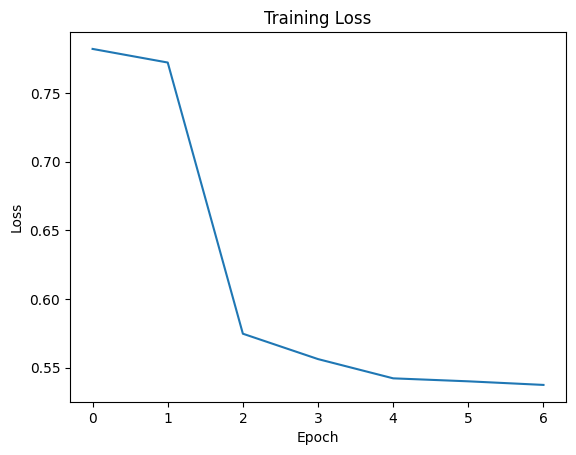

In [ ]:
plt.plot(total_train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
checkpoint_path = '/content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/model/hsv.path'


torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_train_loss,
}, checkpoint_path)

print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: /content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/model/hsv.path


# Loading a saved model

In [ ]:
# Create / load model

class_to_int = {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class = {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
# Initialize the model and optimizer
# model = model  # Initialize your model class
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr = 0.0001)  # Initialize your optimizer


# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [ ]:
itr = 1
v_loss = []

model.to(device)

start_time = time.time()

for images, targets, image_names in tqdm(test_data_loader):

    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    #Forward propagation
    with torch.no_grad():
      out = model(images, targets)
      concatenated_boxes = torch.cat([o['boxes'] for o in out], dim=0)
      # losses = sum(concatenated_boxes.view(-1))
      # losses = sum(o["boxes"].view(-1) for o in out)
      # losses = sum(loss for loss in out.values())
      # losses = sum(out)

    #Average loss
    # loss_value = losses.item()
    # v_loss.append(loss_value)

# val_loss = np.mean(v_loss)
# print(f'Val loss is {val_loss:.4f}')

# time_elapsed = time.time() - start_time
# print("Time elapsed: ",time_elapsed)

  0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 93/93 [00:53<00:00,  1.73it/s]


In [ ]:
pred_results = pd.DataFrame(columns = ["filename", "xmin", "ymin",
                                     "xmax", "ymax", "color"])
pred_results.head()

Empty DataFrame
Columns: [filename, xmin, ymin, xmax, ymax, color]
Index: []

In [ ]:
# Results - may take few mins, please wait!
threshold = 0 #0.7
model.eval()

for images,_ , image_names in test_data_loader:


    # Forward ->
    images = list(image.to(device) for image in images)
    output = model(images)


    # Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    # Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]
    # print(len(boxes_th))

    # int_to_class - labels
    labels_th = []

    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    #Appending results to csv
    for y in range(len(boxes_th)):

        #Bboxes, classname & image name
        x1 = boxes_th[y][0] * 4
        y1 = boxes_th[y][1] * 4
        x2 = boxes_th[y][2] * 4
        y2 = boxes_th[y][3] * 4
        class_name = labels_th[y]


        # Creating row for df
        row = {"filename" : image_names[0],
               "xmin" : x1, "xmax" : x2,
               "ymin" : y1, "ymax" : y2,
               "color" : class_name}
        print(image_names[0])

        # Appending to df
        pred_results = pred_results.append(row, ignore_index = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


00030.jpg
00030.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg
00093.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

00212.jpg
00212.jpg
00212.jpg
00212.jpg
00212.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

00288.jpg
00288.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00330.jpg
00330.jpg
00330.jpg
00330.jpg
00330.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

00364.jpg
00364.jpg
00364.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00418.jpg
00418.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00521.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00584.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00603.jpg
00603.jpg
00603.jpg
00603.jpg
00603.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

00693.jpg
00693.jpg
00693.jpg
00693.jpg
00693.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

00852.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00901.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg
00965.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

00994.jpg
00994.jpg
00994.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


01063.jpg
01063.jpg
01063.jpg
01063.jpg
01063.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg
01129.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg
01203.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

01303.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


01530.jpg
01530.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


01643.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg
01690.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

01852.jpg
01852.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


01905.jpg
01905.jpg
01905.jpg
01905.jpg
01905.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

01931.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


01997.jpg
01997.jpg
01997.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg
02029.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

02075.jpg
02075.jpg
02075.jpg
02075.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg
02136.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg
02154.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

02172.jpg
02172.jpg
02172.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02295.jpg
02295.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg
02340.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

02340.jpg
02362.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02374.jpg
02374.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02392.jpg
02392.jpg
02392.jpg
02392.jpg
02392.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

02438.jpg
02438.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg
02452.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

02452.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02488.jpg
02488.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02558.jpg
02558.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02577.jpg
02577.jpg
02577.jpg
02577.jpg
02577.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

02608.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02679.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02722.jpg
02722.jpg
02722.jpg
02722.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02776.jpg
02776.jpg
02776.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02869.jpg
02869.jpg
02869.jpg
02869.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02906.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02926.jpg
02926.jpg
02926.jpg
02926.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)


02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg
02999.jpg


<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_results = pred_results.append(row, ignore_index = True)
<ipython-input-102-f9364b13e2af>:48: FutureWarning: The frame.append

In [ ]:
pred_results

filename  xmin  ymin  xmax  ymax  color
0    00030.jpg  2244   976  2328  1156    red
1    00030.jpg  2244   976  2328  1156  green
2    00093.jpg  1392  1048  1412  1068    red
3    00093.jpg  1400  1048  1420  1068    red
4    00093.jpg  1396  1040  1412  1060    red
..         ...   ...   ...   ...   ...    ...
216  02999.jpg   164   396   248   572    red
217  02999.jpg   688   808   708   832    red
218  02999.jpg  1892   628  1908   664    red
219  02999.jpg  1884   608  1908   628    red
220  02999.jpg  1880   608  1896   640    red

[221 rows x 6 columns]

In [ ]:
test_df

filename    xmin    ymin    xmax    ymax  color
83    00030.jpg  1688.4  1049.9  1702.9  1098.8    red
84    00030.jpg  1568.3   891.1  1584.5   937.7    red
85    00030.jpg  1502.1   905.2  1534.9   929.2    red
86    00030.jpg  1456.4   889.9  1472.3   936.7    red
98    00036.jpg  1115.6  1115.1  1133.0  1135.9    red
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[1454 rows x 6 columns]

In [ ]:
basePath = '/content/drive/MyDrive/UNT/CSCE 5222/traffic_light_dataset/model'
pred_results.to_csv(basePath+'pred_results_hsv.csv', index = False)

In [ ]:
pred_df = pd.read_csv(basePath+'pred_results_hsv.csv')
pred_df

filename  xmin  ymin  xmax  ymax  color
0    00030.jpg  2244   976  2328  1156    red
1    00030.jpg  2244   976  2328  1156  green
2    00093.jpg  1392  1048  1412  1068    red
3    00093.jpg  1400  1048  1420  1068    red
4    00093.jpg  1396  1040  1412  1060    red
..         ...   ...   ...   ...   ...    ...
216  02999.jpg   164   396   248   572    red
217  02999.jpg   688   808   708   832    red
218  02999.jpg  1892   628  1908   664    red
219  02999.jpg  1884   608  1908   628    red
220  02999.jpg  1880   608  1896   640    red

[221 rows x 6 columns]

In [ ]:
DIR_INPUT = '/content/drive/MyDrive/UNT/Feature Engineering - Sayed/Project/traffic_lights_main_dataset/'

DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"

def plot_img_test(image_name):

    # fig, ax = plt.subplots(1, 1, figsize = (14, 14))
    # ax = ax.flatten()

    bbox = pred_df[pred_df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES_TEST, image_name)
    if os.path.exists(img_path) == False:
      img_path = os.path.join(DIR_IMAGES, image_name)
    # else:
    #   img_path = os.path.join(DIR_IMAGES, image_name)

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image

    # ax[0].set_title('Original Image')
    # ax[0].imshow(image)

    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255,0,0)
        elif label == 'green':
            color_brg = (0,255,0)
        elif label == 'yellow':
            color_brg = (0,255,255)

        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, color_brg, 2)

    plt.figure(figsize=(10,10))
    plt.title('Image with Bondary Box')
    plt.imshow(image2)

    plt.show()

YUV Predictions

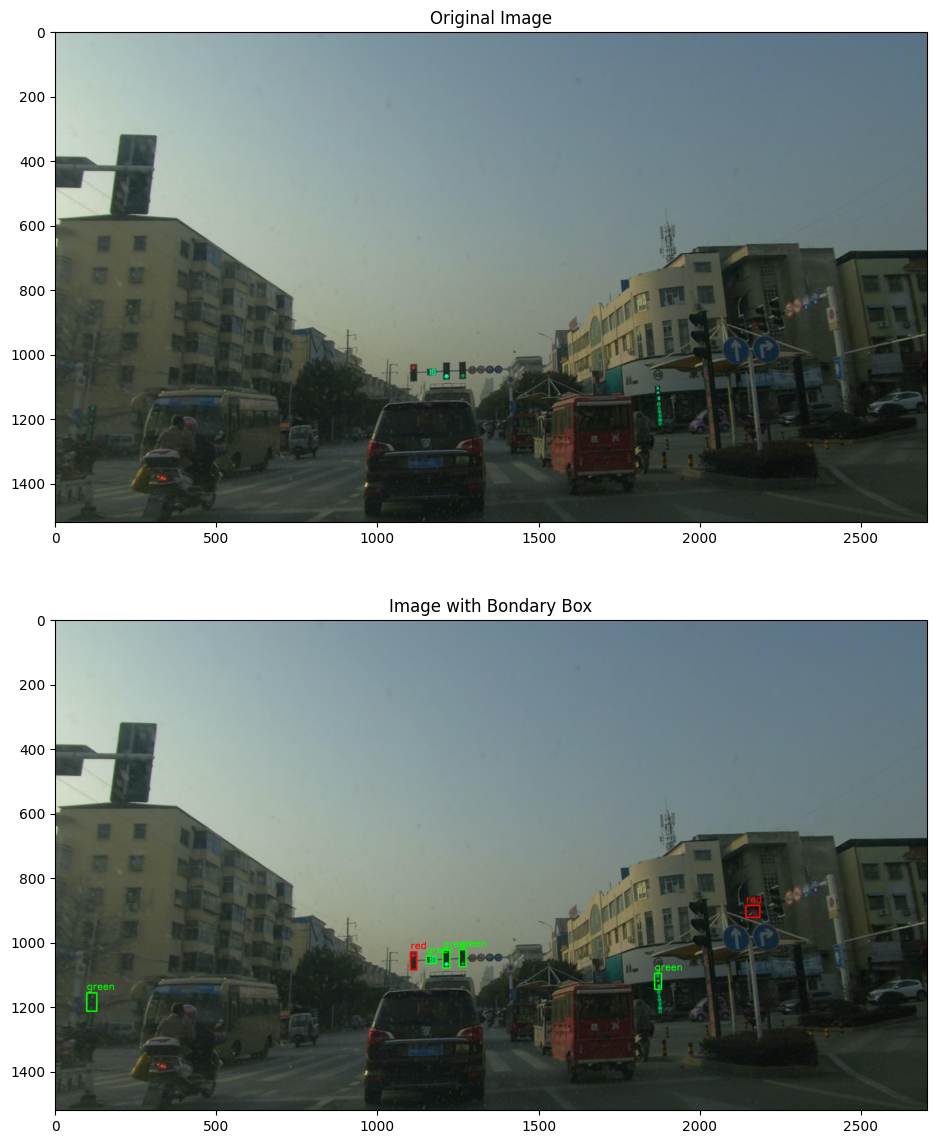

In [ ]:
plot_img("02999.jpg")

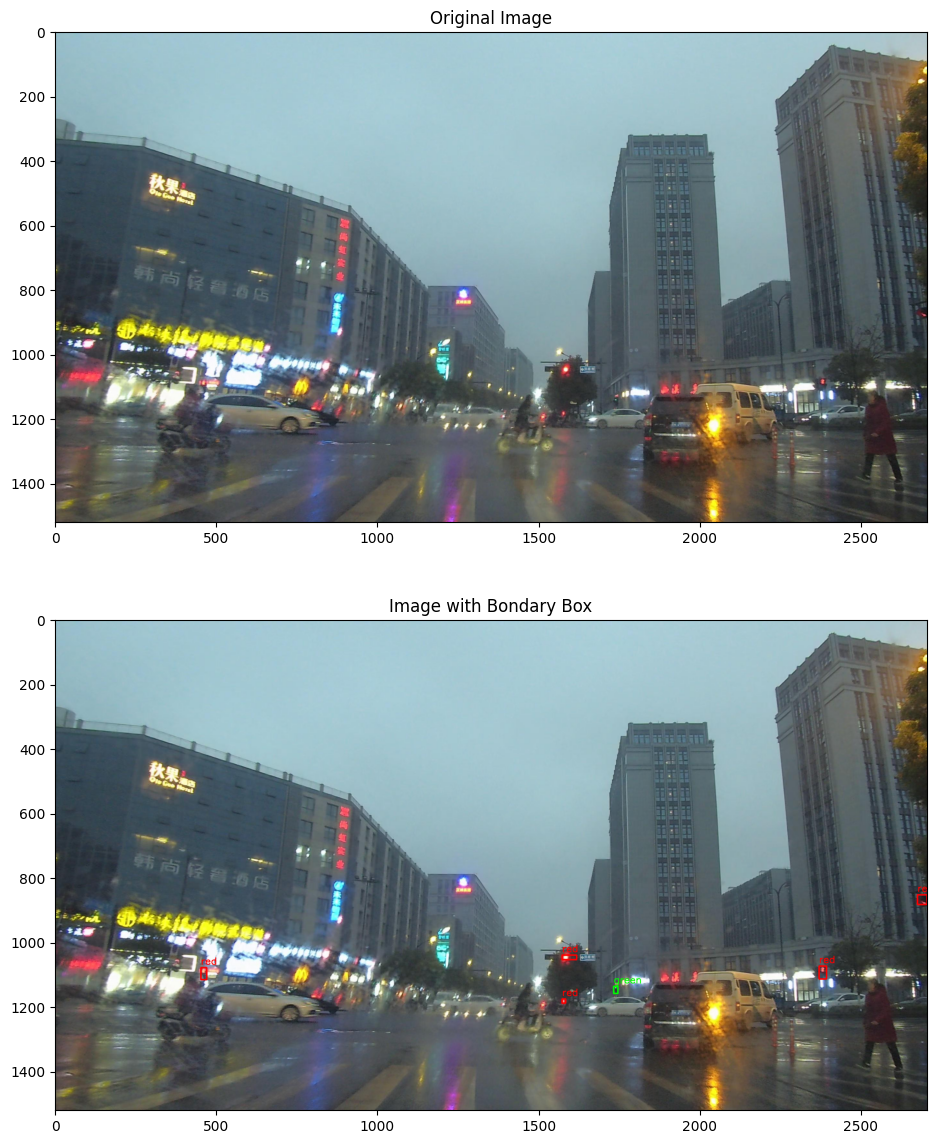

In [ ]:
# 00069
plot_img('02362.jpg')

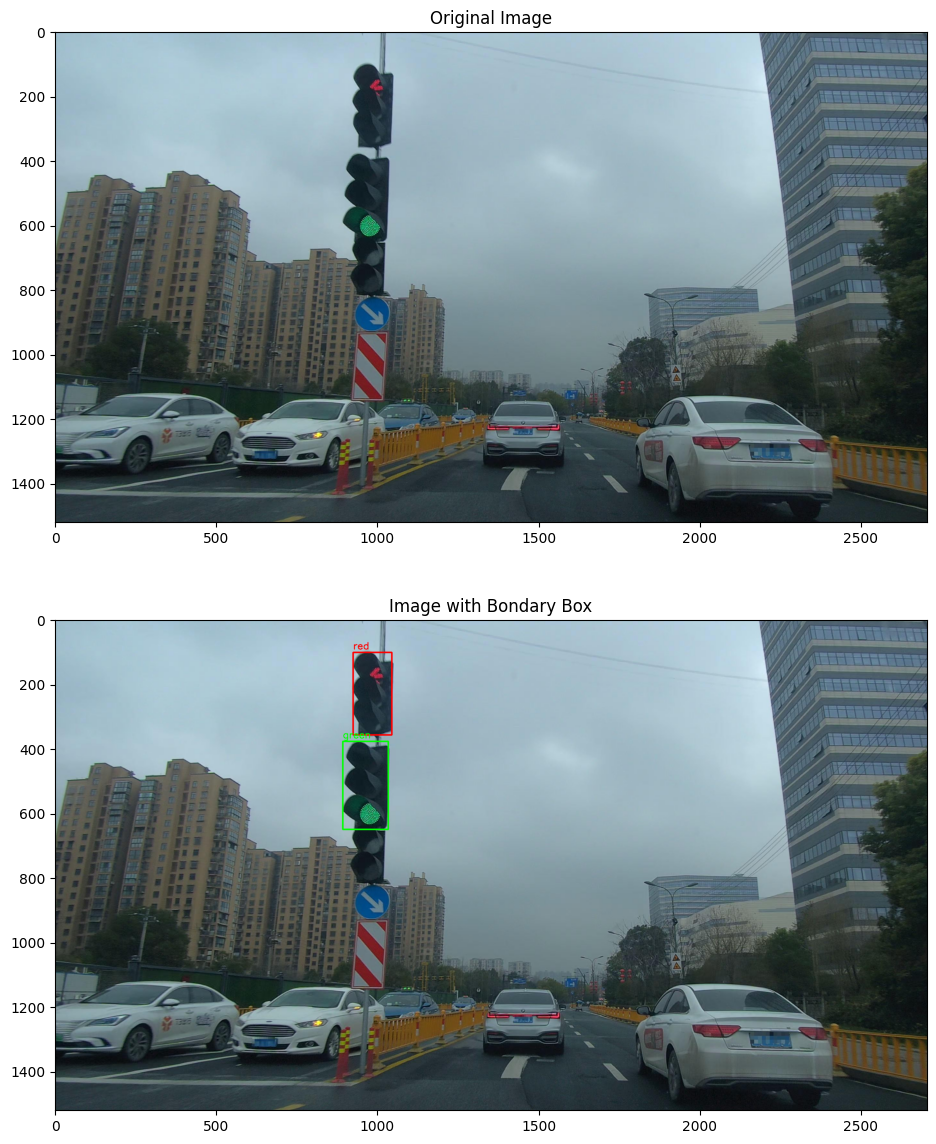

In [ ]:
plot_img('02295.jpg')

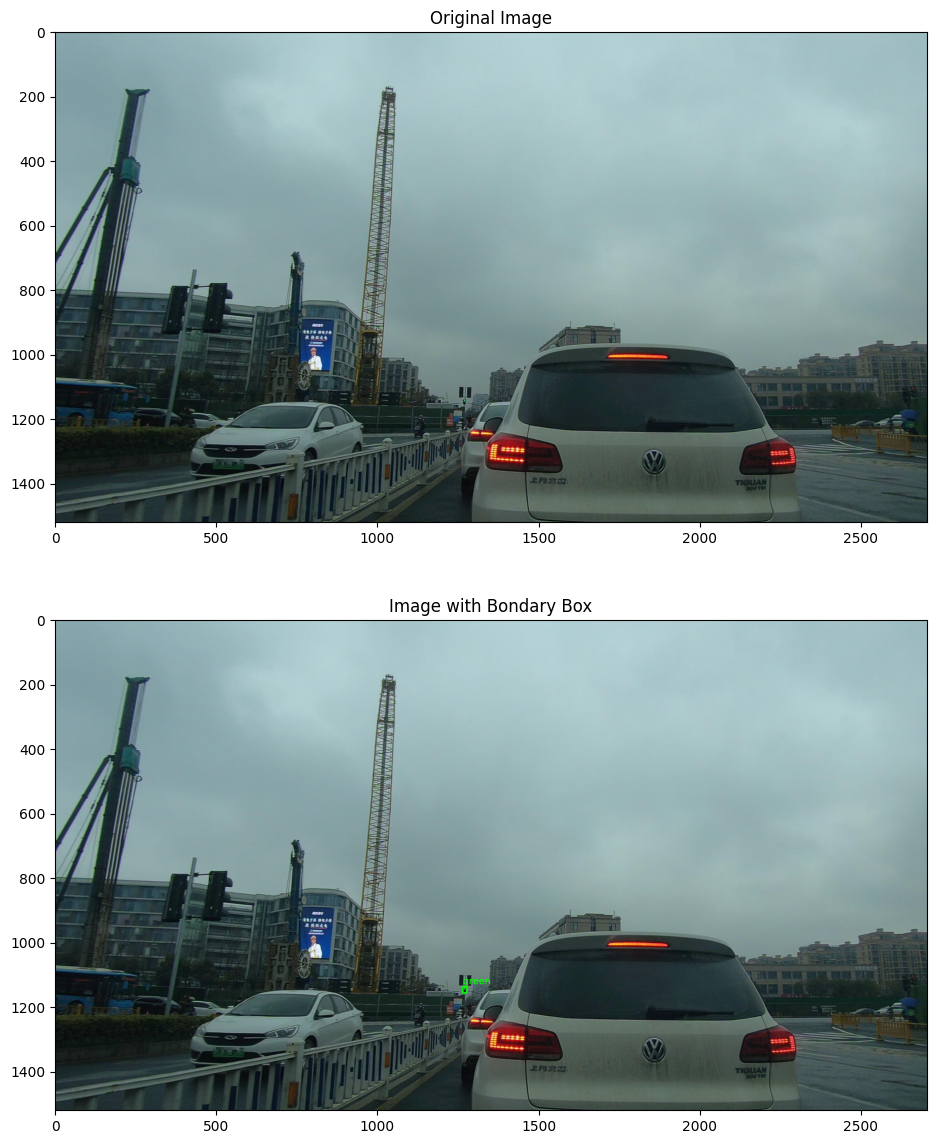

In [ ]:
plot_img('02154.jpg')

# Evaluation

In [ ]:
ground_truth = test_df
pred_data = pred_df

In [ ]:
def csv_to_dict(df):

    # Format csv data to dictonary
    dict_data = {}
    for idx, row in df.iterrows():
        filename = row['filename']
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        label = row['color']

        if filename not in dict_data:
            dict_data[filename] = []

        dict_data[filename].append({'bbox': bbox, 'label': label})
    return dict_data

In [ ]:
ground_truth = csv_to_dict(ground_truth)
pred_data = csv_to_dict(pred_data)

In [ ]:
from shapely.geometry import box
from shapely.ops import unary_union

def calculate_iou(gt_bbox, pred_bbox):
    # Create shapely objects for ground truth and predicted bounding boxes
    gt_box = box(*gt_bbox)
    pred_box = box(*pred_bbox)

    # Calculate intersection and union
    intersection = gt_box.intersection(pred_box).area
    union = unary_union([gt_box, pred_box]).area

    # Calculate IoU
    iou = intersection / union
    return iou

In [ ]:
def evaluate_result(ground_truth, pred):
    iou_threshold = 0.5

    predictions = {}

    # Initializing counters
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_instances = 0

    # Evaluating predictions
    for filename, pred in ground_truth.items():
        if filename in ground_truth:
            gt_list = ground_truth[filename]

    #         total_instances += 1
            total_instances += len(gt_list)

            for pred in pred:
                pred_bbox = pred['bbox']

                # Finding the ground truth bounding box with highest IoU
                max_iou = 0
                match_found = False

                for gt in gt_list:
                    gt_bbox = gt['bbox']
                    iou = calculate_iou(gt_bbox, pred_bbox)

                    if iou > max_iou:
                        max_iou = iou

                if max_iou >= iou_threshold:
                    true_positives += 1
                else:
                    false_positives += 1


    false_negatives = total_instances - true_positives

    # Accuracy
    true_negatives = total_instances - (true_positives + false_positives + false_negatives)
    accuracy = (true_positives + true_negatives)/total_instances

    # Calculating precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return(accuracy, precision, recall, f1_score)

In [ ]:
evaluate_result(ground_truth, pred_data)

(1.0, 1.0, 1.0, 1.0)